In [1]:
import time
import os

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets

from tqdm.notebook import tqdm

import numpy as np
from matplotlib import pyplot as plt
from random import randint

### Part 1: Loading the Data

In [2]:
batch_size = 32
data_root = './data/cifar10'
transform = T.Compose([
    T.ToTensor(),
    # scales pixel values to range [-1, 1]
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# We will set up an 80-20 training validation split.
# That is, we will designate 80% of the 50k samples in the CIFAR10 training data as our training set
# and the remaining 20% as the validation set
train_size = 40_000
val_size = 10_000

dataset = torchvision.datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform,
)
assert train_size + val_size <= len(dataset), "Trying to sample too many elements!" \
    "Please lower the train or validation set sizes."
train_set, val_set, _ = torch.utils.data.random_split(
    dataset, [train_size, val_size, len(dataset) - train_size - val_size]
)
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck',
)

100%|██████████| 170M/170M [00:11<00:00, 14.5MB/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


In [3]:
# This line will create the PyTorch dataloaders associated with the training and validation sets.
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

showing training images


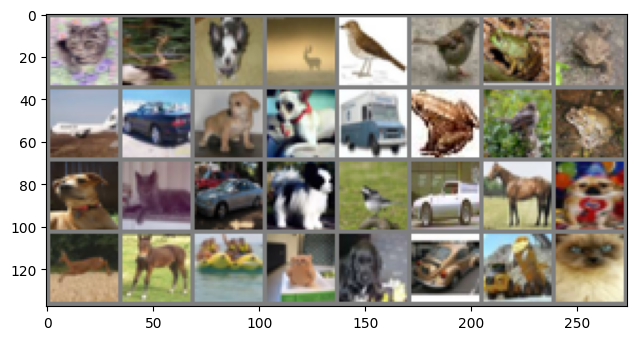

In [4]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.5, 7.5]

def show_image(img):
    img = img / 2 + 0.5
    img = img.numpy()
    img = img.transpose([1, 2, 0])
    plt.imshow(img)
    plt.show()

images, labels = next(iter(train_loader))
nrow = 4
print('showing training images')
show_image(torchvision.utils.make_grid(images, nrow=batch_size // nrow))
print('\n... and their corresponding labels')
for idxs in np.array_split(np.arange(batch_size), nrow):
    print(' '.join(f'{classes[labels[j]]:8s}' for j in idxs))

### Part 2: Fully Connected Neural Network

In [5]:
class FCNN(nn.Module):
    def __init__(self, layer_dims):
        '''
        Initialize the torch.nn.Module and define some layers for future use
        layer_dims: list of integers: the first integer is the input dimension
            and all subsequent elements represent the width
            of each layer in our NN. For simplicity, you may assume
            that len(layer_dims) == 3
        '''
        super(FCNN, self).__init__()
        # Define linear layers
        self.layer1 = nn.Linear(layer_dims[0], layer_dims[1])
        self.layer2 = nn.Linear(layer_dims[1], layer_dims[2])

    def forward(self, x):
        '''
        Compute a forward pass of your batch of images

        x: torch.Tensor of shape (batch_size, num_channels, width, height)
        returns: result of passing x through your network
        '''
        # Flatten the images
        x = x.view(x.size(0), -1)  # Flatten each image in the batch

        # Pass through layers with ReLU activation
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)

        return x


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def compute_accuracy(model, loader):
    total_correct = 0

    # Put the model on the right device and enable eval mode
    model.to(device)
    model.eval()

    for inputs, labels in tqdm(loader, leave=False):
        # Move inputs and labels to the correct device
        inputs, labels = inputs.to(device), labels.to(device)

        # Compute model outputs
        outputs = model(inputs)

        # Calculate the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()

    return total_correct / len(loader.dataset)

def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, path=None, scheduler=None):
    print('Beginning to train model')
    if path and not os.path.exists(path):
        os.makedirs(path)

    # Put the model on the correct device
    model.to(device)

    for epoch in tqdm(range(1, num_epochs + 1)):
        model.train()
        total_loss = 0
        start_time = time.perf_counter()

        for inputs, labels in tqdm(train_loader, leave=False):
            # Move inputs and labels to the correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero out gradients
            optimizer.zero_grad()

            # Compute model outputs and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backpropagate and perform an optimizer step
            loss.backward()
            optimizer.step()

            # Update the total loss
            total_loss += loss.item()

        if path:
            torch.save(model.state_dict(), f'{path}/model_ep_{epoch:02d}.pth')

        end_time = time.perf_counter()
        duration = end_time - start_time

        # Compute training and validation accuracies
        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, val_loader)

        # Adjust the learning rate if using a scheduler
        current_lr = optimizer.param_groups[0]['lr']
        if scheduler and current_lr > 5e-5:
            scheduler.step()

        print(f'epoch {epoch:2}',
              f'loss: {total_loss:.3f}',
              f'time: {duration:.3f}',
              f'train acc: {train_acc:.4f}',
              f'val acc: {val_acc:.4f}', sep='\t')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [8]:
num_epochs = 15
layer_dims = [3072, 100, 10]
fcnn = FCNN(layer_dims)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcnn.parameters(), lr=1e-3, momentum=0.9)

In [9]:
train(fcnn, train_loader, val_loader, num_epochs, criterion, optimizer)

Beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 2288.601	time: 26.706	train acc: 0.4201	val acc: 0.4141


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 2022.551	time: 21.918	train acc: 0.4586	val acc: 0.4472


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 1922.082	time: 21.626	train acc: 0.4833	val acc: 0.4655


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 1851.268	time: 20.297	train acc: 0.5011	val acc: 0.4771


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 1794.313	time: 20.243	train acc: 0.5240	val acc: 0.4876


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 1742.784	time: 20.754	train acc: 0.5363	val acc: 0.4980


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 1698.772	time: 23.825	train acc: 0.5432	val acc: 0.5031


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 1658.245	time: 21.993	train acc: 0.5618	val acc: 0.5093


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 1621.081	time: 22.322	train acc: 0.5738	val acc: 0.5132


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 1587.599	time: 21.282	train acc: 0.5824	val acc: 0.5136


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 1555.499	time: 20.488	train acc: 0.5880	val acc: 0.5141


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 1526.339	time: 20.729	train acc: 0.5976	val acc: 0.5156


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 1496.171	time: 20.819	train acc: 0.5975	val acc: 0.5179


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 1469.208	time: 22.409	train acc: 0.6064	val acc: 0.5148


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 1443.525	time: 22.510	train acc: 0.6280	val acc: 0.5246


In [10]:
print(count_parameters(fcnn))

308310


### Part 3: Basic Convolutional Neural Network

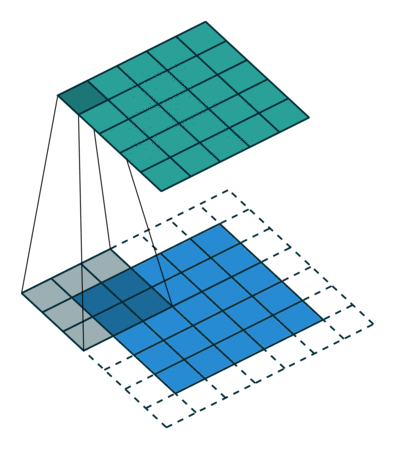

In [12]:
class CNN(nn.Module):
    def __init__(self):
        '''
        Initialize the torch.nn.Module and define some layers for future use.
        '''
        super(CNN, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=16, kernel_size=5)

        # Define the fully connected (linear) layers
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)  # Assuming input image size is 32x32
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        '''
        Compute a forward pass of your batch of images
        '''
        # Pass through first conv layer, ReLU activation, and pooling
        x = self.pool(torch.relu(self.conv1(x)))

        # Pass through second conv layer, ReLU activation, and pooling
        x = self.pool(torch.relu(self.conv2(x)))

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers with ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # Final layer (no activation)
        x = self.fc3(x)

        return x


In [13]:
num_epochs = 15
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=1e-3, momentum=0.9)

In [14]:
train(cnn, train_loader, val_loader, num_epochs, criterion, optimizer)

Beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 2851.114	time: 32.109	train acc: 0.1985	val acc: 0.1968


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 2496.865	time: 28.142	train acc: 0.3421	val acc: 0.3429


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 2152.846	time: 28.514	train acc: 0.4086	val acc: 0.4069


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 1975.351	time: 28.671	train acc: 0.4644	val acc: 0.4604


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 1842.462	time: 28.548	train acc: 0.4792	val acc: 0.4726


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 1748.235	time: 28.524	train acc: 0.5143	val acc: 0.5041


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 1675.305	time: 28.441	train acc: 0.5364	val acc: 0.5205


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 1601.909	time: 28.642	train acc: 0.5644	val acc: 0.5435


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 1538.701	time: 28.767	train acc: 0.5704	val acc: 0.5401


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 1493.886	time: 28.757	train acc: 0.5978	val acc: 0.5688


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 1446.958	time: 29.314	train acc: 0.6092	val acc: 0.5743


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 1402.694	time: 33.025	train acc: 0.6133	val acc: 0.5805


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 1366.969	time: 28.890	train acc: 0.6356	val acc: 0.5965


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 1327.988	time: 28.942	train acc: 0.6368	val acc: 0.5967


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 1295.789	time: 28.841	train acc: 0.6377	val acc: 0.5856


In [15]:
fcnn_num_params = count_parameters(fcnn)
cnn_num_params = count_parameters(cnn)
print('FCNN Num Params:', fcnn_num_params)
print('CNN Num Params:', cnn_num_params)
print('Ratio:', cnn_num_params/fcnn_num_params)

FCNN Num Params: 308310
CNN Num Params: 61530
Ratio: 0.19957185949206968


### Part 4: Using ResNet for Classification

In [18]:
class ResNetBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        '''
        Create a residual block for our ResNet18 architecture.

        Here is the expected network structure:
        - conv layer with
            out_channels=out_channels, 3x3 kernel, stride=stride
        - batchnorm layer
        - conv layer with
            out_channels=out_channels, 3x3 kernel, stride=1
        - batchnorm layer
        - shortcut layer:
            if either the stride is not 1 or the out_channels is not equal to in_channels:
                the shortcut layer is composed of two steps:
                - conv layer with
                    in_channels=in_channels, out_channels=out_channels, 3x3 kernel, stride=stride
                - batchnorm layer
            else:
                the shortcut layer should be a no-op

        All conv layers will have a padding of 1 and no bias term. To facilitate this, consider using
        the provided conv() helper function.
        When performing a forward pass, the ReLU activation should be applied after the first batchnorm layer
        and after the second batchnorm gets added to the shortcut.
        '''
        super(ResNetBlock, self).__init__()

        # Define the first conv layer, batchnorm, and stride
        self.conv1 = self.conv(in_channels, out_channels, kernel_size=3, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Define the second conv layer and batchnorm
        self.conv2 = self.conv(out_channels, out_channels, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Define the shortcut layer
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                self.conv(in_channels, out_channels, kernel_size=3, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
    def conv(self, in_channels, out_channels, kernel_size, stride):
        return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1, bias=False)

    def forward(self, x):
        '''
        Compute a forward pass of this batch of data with this residual block.

        x: batch of images of shape (batch_size, num_channels, width, height)
        returns: result of passing x through this block
        '''
          # First conv layer, followed by batchnorm and ReLU
        out = F.relu(self.bn1(self.conv1(x)))

        # Second conv layer, followed by batchnorm
        out = self.bn2(self.conv2(out))

        # Apply the shortcut layer to x
        shortcut = self.shortcut(x)

        # Add the shortcut and apply ReLU
        out += shortcut
        out = F.relu(out)

        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=64,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.in_channels = 64
        self.layer1 = self.make_block(out_channels=64, stride=1, rep=2)
        self.layer2 = self.make_block(out_channels=128, stride=2, rep=2)
        self.layer3 = self.make_block(out_channels=256, stride=2, rep=2)
        self.layer4 = self.make_block(out_channels=512, stride=2, rep=2)
        self.linear = nn.Linear(512, num_classes)

    def make_block(self, out_channels, stride, rep):
        layers = []
        for stride in [stride, 1]:
            layers.append(ResNetBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 4)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

In [19]:
num_epochs = 15
resnet = ResNet18(num_classes = 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=1e-3, momentum=0.9)

In [20]:
resnet = resnet.to(device)
summary(resnet, input_size = (3, 32, 32), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,728
       BatchNorm2d-2           [32, 64, 32, 32]             128
            Conv2d-3           [32, 64, 32, 32]          36,864
       BatchNorm2d-4           [32, 64, 32, 32]             128
            Conv2d-5           [32, 64, 32, 32]          36,864
       BatchNorm2d-6           [32, 64, 32, 32]             128
       ResNetBlock-7           [32, 64, 32, 32]               0
            Conv2d-8           [32, 64, 32, 32]          36,864
       BatchNorm2d-9           [32, 64, 32, 32]             128
           Conv2d-10           [32, 64, 32, 32]          36,864
      BatchNorm2d-11           [32, 64, 32, 32]             128
      ResNetBlock-12           [32, 64, 32, 32]               0
           Conv2d-13          [32, 128, 16, 16]          73,728
      BatchNorm2d-14          [32, 128,

In [21]:
train(resnet, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_resnet')

Beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 1686.198	time: 3632.818	train acc: 0.6464	val acc: 0.6099


  0%|          | 0/1250 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Part 5: Optimizing Hyperparameters and Other Tricks

In [24]:
import shutil
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision import datasets
import torch

# Remove previous data and loaders if they exist
try:
    shutil.rmtree("./data")
    del train_loader, val_loader
except:
    pass

data_root = './data/cifar10'
train_size = 40_000
val_size = 10_000

# Define hyperparameters and transformations
batch_size = 32
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

transform_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.95, 1.05)),
    # Removed T.ToTensor() as it's already applied during dataset loading
    T.Normalize(mean, std),
])

transform_val = T.Compose([
    # Removed T.ToTensor() as it's already applied during dataset loading
    T.Normalize(mean, std),
])

# Load CIFAR-10 dataset
# Removed transform=T.ToTensor() here as well
dataset = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    # transform is removed to apply the desired transformations later
)

# Ensure dataset split sizes are valid
assert train_size + val_size <= len(dataset), "Trying to sample too many elements!" \
    "Please lower the train or validation set sizes."

# Split dataset indices for training and validation
train_split, val_split, _ = torch.utils.data.random_split(
    range(len(dataset)), [train_size, val_size, len(dataset) - train_size - val_size]
)

# Define Custom Dataset Class with Transformations
class CustomTransformDataset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.transform = transform
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]
        # Apply ToTensor here to ensure image is converted to Tensor
        return self.transform(T.ToTensor()(x)), y

# Create training and validation sets with custom transformations
train_set = CustomTransformDataset(dataset, train_split, transform=transform_train)
val_set = CustomTransformDataset(dataset, val_split, transform=transform_val)

# Define DataLoaders for training and validation sets
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

100%|██████████| 170M/170M [00:12<00:00, 14.0MB/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


showing training images


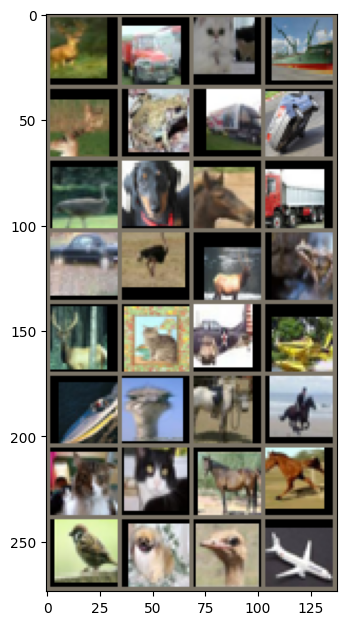


... and their corresponding labels
deer     truck    cat      ship    
deer     frog     truck    car     
bird     dog      horse    truck   
car      bird     deer     frog    
deer     cat      plane    plane   
ship     bird     horse    horse   
cat      cat      horse    horse   
bird     dog      bird     plane   


In [25]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.5, 7.5]

def show_image(img):
    img = img * std.reshape(-1, 1, 1) + mean.reshape(-1, 1, 1)
    img = img.numpy()
    img = img.transpose([1, 2, 0])
    plt.imshow(img)
    plt.show()

images, labels = next(iter(train_loader))
nrow = 8
print('showing training images')
show_image(torchvision.utils.make_grid(images, nrow=batch_size // nrow))
print('\n... and their corresponding labels')
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck',
)
for idxs in np.array_split(np.arange(batch_size), nrow):
    print(' '.join(f'{classes[labels[j]]:8s}' for j in idxs))

In [28]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut layer to handle mismatched channels or stride
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet34(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet34, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        layers = [ResNetBlock(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        return self.fc(x)

final_cnn = ResNet34(num_classes=10)


In [40]:
import torch.optim as optim
import torchvision.transforms as T
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Set up device for GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Updated data transformations with more augmentation for training
transform_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),  # Rotate by up to 10 degrees
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transform_val = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Move model to GPU
final_cnn.to(device)

# Hyperparameters
num_epochs = 25
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(final_cnn.parameters(), lr=0.001, weight_decay=5e-4)

# Cosine Annealing Learning Rate Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Mixed Precision Training
scaler = GradScaler()

# Updated training function to include GPU support
def train_with_gpu(model, train_loader, val_loader, num_epochs, criterion, optimizer, scheduler=None):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0

        # Training loop
        for inputs, labels in train_loader:
            # Move inputs and labels to the GPU
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            # Mixed Precision forward pass
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Backward pass with gradient scaling for mixed precision
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)

        # Scheduler step
        if scheduler:
            scheduler.step()

        # Validation loop (also moved to GPU)
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        # Print training and validation loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader.dataset):.4f}, Val Loss: {val_loss/len(val_loader.dataset):.4f}')
    model.train()

# Re-run training with GPU and mixed precision support
train_with_gpu(final_cnn, train_loader, val_loader, num_epochs, criterion, optimizer, scheduler)


<ipython-input-40-682fd20f58d2>:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-40-682fd20f58d2>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-40-682fd20f58d2>:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/25], Train Loss: 1.7934, Val Loss: 1.5333


KeyboardInterrupt: 